In [1]:
# !pip install stim -q
# !pip install stimcirq -q
# !pip install pymatching~=2.0 -q

In [2]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))  # increase cell width
display(
    HTML("<style>div.output_area pre {white-space: pre;}</style>")
)  # horizontal scrolling instead of newlines for printed output
%reload_ext autoreload
%autoreload 2

In [3]:
import stim
import cirq
import stimcirq
import qldpc
import pymatching
import numpy as np
import cirq_superstaq as css

In [101]:
circuit = stim.Circuit.generated(
    "color_code:memory_xyz",
    rounds=3,
    distance=3,
    before_round_data_depolarization=0.04,
    before_measure_flip_probability=0.01)

print(repr(circuit))

stim.Circuit('''
    QUBIT_COORDS(0, 0) 0
    QUBIT_COORDS(1, 0) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 0) 3
    QUBIT_COORDS(0.5, 1) 4
    QUBIT_COORDS(1.5, 1) 5
    QUBIT_COORDS(2.5, 1) 6
    QUBIT_COORDS(1, 2) 7
    QUBIT_COORDS(2, 2) 8
    QUBIT_COORDS(1.5, 3) 9
    R 0 1 2 3 4 5 6 7 8 9
    REPEAT 2 {
        TICK
        DEPOLARIZE1(0.04) 0 1 3 5 6 7 9
        C_XYZ 0 1 3 5 6 7 9
        TICK
        CX 5 4 3 2
        TICK
        CX 7 4 6 2
        TICK
        CX 1 4 6 8
        TICK
        CX 1 2 7 8
        TICK
        CX 5 2 9 8
        TICK
        CX 0 4 5 8
        TICK
        X_ERROR(0.01) 2 4 8
        MR 2 4 8
    }
    DETECTOR(2, 0, 0) rec[-3] rec[-6]
    DETECTOR(0.5, 1, 0) rec[-2] rec[-5]
    DETECTOR(2, 2, 0) rec[-1] rec[-4]
    TICK
    DEPOLARIZE1(0.04) 0 1 3 5 6 7 9
    C_XYZ 0 1 3 5 6 7 9
    TICK
    CX 5 4 3 2
    TICK
    CX 7 4 6 2
    TICK
    CX 1 4 6 8
    TICK
    CX 1 2 7 8
    TICK
    CX 5 2 9 8
    TICK
    CX 0 4 5 8
    TICK
    X_ERR

In [80]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=3,
    distance=3,
    before_round_data_depolarization=0.04,
    before_measure_flip_probability=0.01)

print(repr(circuit))

stim.Circuit('''
    R 0 1 2 3 4
    TICK
    DEPOLARIZE1(0.04) 0 2 4
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    X_ERROR(0.01) 1 3
    MR 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    REPEAT 2 {
        TICK
        DEPOLARIZE1(0.04) 0 2 4
        CX 0 1 2 3
        TICK
        CX 2 1 4 3
        TICK
        X_ERROR(0.01) 1 3
        MR 1 3
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-2] rec[-4]
        DETECTOR(3, 0) rec[-1] rec[-3]
    }
    X_ERROR(0.01) 0 2 4
    M 0 2 4
    DETECTOR(1, 1) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 1) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
''')


In [4]:
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_x",
    rounds=3,
    distance=3,
    before_round_data_depolarization=0.04,
    before_measure_flip_probability=0.01)

print(repr(circuit))

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    RX 1 3 5 8 10 12 15 17 19
    R 2 9 11 13 14 16 18 25
    TICK
    DEPOLARIZE1(0.04) 1 3 5 8 10 12 15 17 19
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    X_ERROR(0.01) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    DETECTOR(2, 0, 0) rec[-8]
    DETECTOR(2, 4, 0) rec[-3]
    DETECTOR(4, 2, 0) rec[-6]
    DETECTOR(4, 6, 0) rec[-1]
  

In [5]:
# print(repr(stimcirq.stim_circuit_to_cirq_circuit(circuit)))

In [6]:
def stim_steane_code(error_rate):
# steane code metadata
    steane_code = qldpc.codes.SteaneCode()
    code = steane_code
    repetitions = 10
    stabilizers = []
    
    circuit = cirq.Circuit()
    ancillas = []
    stab_circuit = cirq.Circuit()
    for anc_idx, check in enumerate(code.matrix_x):
        anc = cirq.NamedQubit(f"a{anc_idx}")
        # anc = cirq.LineQubit(7 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CX(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
        
    # circuit += css.barrier(*circuit.all_qubits())
    
    for anc_idx, check in enumerate(code.matrix_z):
        anc = cirq.NamedQubit(f"a{anc_idx + 3}")
        # anc = cirq.LineQubit(7 + 3 + anc_idx)
        ancillas.append(anc)
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(check):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CZ(anc, cirq.LineQubit(bit_idx))
                stabilizers.append(cirq.CZ(anc, cirq.LineQubit(bit_idx)))
        stab_circuit += cirq.H(anc)
    data = sorted([q for q in stab_circuit.all_qubits() if isinstance(q, cirq.LineQubit)])
    qubits = list(stab_circuit.all_qubits())
    
    circuit = cirq.Circuit()
    for q in qubits:
        # circuit += cirq.R(q)
        circuit += stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q)
    stab_circuit = cirq.Circuit()
    stab_circuit += cirq.Moment([cirq.depolarize(error_rate).on(d) for d in data] + cirq.H.on_each(ancillas))
    stab_circuit += cirq.Circuit(cirq.Moment(stab) for stab in stabilizers)
    stab_circuit += cirq.Moment(cirq.H.on_each(ancillas))
    circuit += stab_circuit
    circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    circuit += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    circuit += cirq.Moment(
        stimcirq.DetAnnotation(relative_keys=[-6], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-5], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-4], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-3], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-2], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-1], coordinate_metadata=(12.0, 0.0))
    )
    
    circuit_op = stab_circuit
    circuit_op += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='X', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))

    moment += cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    moment += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[-len(ancillas) + idx, idx], coordinate_metadata=(len(qubits) + idx, 0)) for idx in range(-len(ancillas), 0)])

    # moment += cirq.Moment(
    #     stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-12, -6], coordinate_metadata=(7.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-11, -5], coordinate_metadata=(8.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-10, -4], coordinate_metadata=(9.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-9, -3], coordinate_metadata=(10.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-8, -2], coordinate_metadata=(11.0, 0.0)),
    #     stimcirq.DetAnnotation(relative_keys=[-7, -1], coordinate_metadata=(12.0, 0.0))
    # )
    
    circuit_op += moment
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))
    
    for idx, d in enumerate(data):
        circuit += cirq.X.with_probability(error_rate).on(d)
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    
    circuit += cirq.Moment(
        stimcirq.ShiftCoordsAnnotation((0.0, 1.0)),
        stimcirq.DetAnnotation(relative_keys=[-13, -1, -2, -3, -4], coordinate_metadata=(7.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-12, -1, -2, -5, -6], coordinate_metadata=(8.0, 0.0)),
        stimcirq.DetAnnotation(relative_keys=[-11, -1, -3, -5, -7], coordinate_metadata=(9.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-10, -1, -2, -3, -4], coordinate_metadata=(10.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-9, -1, -2, -5, -6], coordinate_metadata=(11.0, 0.0)),
        # stimcirq.DetAnnotation(relative_keys=[-8, -1, -3, -5, -7], coordinate_metadata=(12.0, 0.0))
    )
    circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(relative_keys=[-1, -2, -3], observable_index=0))
    
    # return circuit.with_noise(cirq.depolarize(noise))
    return circuit

In [120]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int, decompose_errors=True, ignore_decomposition_failures=False) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model()
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    print(detection_events, detection_events.size)
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [121]:
from sympy.abc import x, y, z
dims = {x: 12, y: 6}
poly_a = x**3 + y + y**2
poly_b = y**3 + x + x**2

# dims = (12, 4)
# poly_a = 1 + y + x * y + x**9
# poly_b = 1 + x**2 + x**7 + x**9 * y**2
code = qldpc.codes.BBCode(dims, poly_a, poly_b)

In [122]:
import matplotlib.pyplot as plt
code = qldpc.codes.BBCode(dims, poly_a, poly_b)

num_shots = 10_000
xs = []
ys = []
for noise in [0.002, 0.004, 0.006, 0.008, 0.01]:
    circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(code, 12, noise))
    num_errors_sampled = count_logical_errors(circuit, num_shots, False, False)
    xs.append(noise)
    ys.append(num_errors_sampled / num_shots)
plt.plot(xs, ys)
plt.plot(xs, xs, "--")
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for X corrections")
plt.legend()
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]] 17280000


ValueError: No perfect matching could be found. This likely means that the syndrome has odd parity in the support of a connected component without a boundary.

In [130]:
circuit.diagram(
    "detslice-with-ops-svg",
    tick=range(771, 775),
    filter_coords=["D1368", "D1369", "D1424"],
)

In [104]:
dem = circuit.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.00133333) D0 D1 D56
    error(0.00133333) D0 D5 D55
    error(0.00133333) D0 D6 D15 L10 L11
    error(0.00133333) D0 D9 D66
    error(0.00133333) D0 D22 D23
    error(0.00133333) D0 D63 D69
    error(0.00133333) D1 D2 D57
    error(0.00133333) D1 D7 D16 L8 L10 L11
    error(0.00133333) D1 D10 D67
    error(0.00133333) D1 D18 D23
    error(0.00133333) D1 D56 D72
    error(0.00133333) D1 D64 D70
    error(0.00133333) D2 D3 D58
    error(0.00133333) D2 D8 D17 L8 L9 L10 L11
    error(0.00133333) D2 D11 D68 L2 L3
    error(0.00133333) D2 D18 D19
    error(0.00133333) D2 D57 D73
    error(0.00133333) D2 D65 D71
    error(0.00133333) D3 D4 D59
    error(0.00133333) D3 D6 D69 L3
    error(0.00133333) D3 D9 D12 L8 L9 L11
    error(0.00133333) D3 D19 D20
    error(0.00133333) D3 D58 D74
    error(0.00133333) D3 D60 D66
    error(0.00133333) D4 D5 D54
    error(0.00133333) D4 D7 D70 L2 L3
    error(0.00133333) D4 D10 D13 L8 L9
    error(0.00133333) D4 D20 D

In [99]:
circuit

stim.Circuit('''
    RX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
    R 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 

In [98]:
circuit[1155]

stim.CircuitRepeatBlock(11, stim.Circuit('''
    H 144
    DEPOLARIZE1(0.002) 1 2 18 75 78 84
    H 145
    DEPOLARIZE1(0.002) 3 19 76 79 85
    H 146
    DEPOLARIZE1(0.002) 4 20 77 80 86
    H 147
    DEPOLARIZE1(0.002) 5 21 72 81 87
    H 148
    DEPOLARIZE1(0.002) 0 22 73 82 88
    H 149
    DEPOLARIZE1(0.002) 23 74 83 89
    H 150
    DEPOLARIZE1(0.002) 7 8 24 90
    H 151
    DEPOLARIZE1(0.002) 9 25 91
    H 152
    DEPOLARIZE1(0.002) 10 26 92
    H 153
    DEPOLARIZE1(0.002) 11 27 93
    H 154
    DEPOLARIZE1(0.002) 6 28 94
    H 155
    DEPOLARIZE1(0.002) 29 95
    H 156
    DEPOLARIZE1(0.002) 13 14 30 96
    H 157
    DEPOLARIZE1(0.002) 15 31 97
    H 158
    DEPOLARIZE1(0.002) 16 32 98
    H 159
    DEPOLARIZE1(0.002) 17 33 99
    H 160
    DEPOLARIZE1(0.002) 12 34 100
    H 161
    DEPOLARIZE1(0.002) 35 101
    H 162
    DEPOLARIZE1(0.002) 36 102
    H 163
    DEPOLARIZE1(0.002) 37 103
    H 164
    DEPOLARIZE1(0.002) 38 104
    H 165
    DEPOLARIZE1(0.002) 39 105
    H 166
 

In [63]:
circuit[1155].body_copy()[770:775]

stim.Circuit('''
    DEPOLARIZE1(0.002) 128
    CX 274 52 276 54
    DEPOLARIZE1(0.002) 64
    CX 279 57
    DEPOLARIZE1(0.002) 69
''')

In [94]:
help(circuit.diagram)

Help on method diagram in module stim._stim_sse2:

diagram(...) method of stim._stim_sse2.Circuit instance
    diagram(self: stim._stim_sse2.Circuit, type: str = 'timeline-text', *, tick: object = None, filter_coords: object = None) -> stim._stim_sse2._DiagramHelper
    
    @overload def diagram(self, type: 'Literal["timeline-text"]') -> 'stim._DiagramHelper':
    @overload def diagram(self, type: 'Literal["timeline-svg"]', *, tick: Union[None, int, range] = None) -> 'stim._DiagramHelper':
    @overload def diagram(self, type: 'Literal["timeline-3d", "timeline-3d-html"]') -> 'stim._DiagramHelper':
    @overload def diagram(self, type: 'Literal["matchgraph-svg"]') -> 'stim._DiagramHelper':
    @overload def diagram(self, type: 'Literal["matchgraph-3d"]') -> 'stim._DiagramHelper':
    @overload def diagram(self, type: 'Literal["matchgraph-3d-html"]') -> 'stim._DiagramHelper':
    @overload def diagram(self, type: 'Literal["detslice-text"]', *, tick: int, filter_coords: Iterable[Union[It

In [84]:
import stimcirq
import qldpc
import cirq

surface_code = qldpc.codes.SurfaceCode(3, rotated=True)
surface_code.reduce_logical_ops()

def gen_syndrome_surface_circuit(surface_code, repetitions=1, error_rate=0.01):
    circuit = cirq.Circuit()
    stab_circuit = cirq.Circuit()
    # logical_x = surface_code.get_random_logical_op(qldpc.objects.Pauli.X, ensure_nontrivial=True)
    # logical_z = surface_code.get_random_logical_op(qldpc.objects.Pauli.Z, ensure_nontrivial=True)
    logical_x = surface_code.get_logical_ops(qldpc.objects.Pauli.X)
    logical_z = surface_code.get_logical_ops(qldpc.objects.Pauli.Z)
    # for iteration in range(loops):
    count = 0
    measures = []
    hs = []
    for anc_idx, row in enumerate(surface_code.matrix_x):
        count += 1
        anc = cirq.NamedQubit(f"a{anc_idx}")
        stab_circuit += cirq.H(anc)
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
        hs.append(cirq.H(anc))
        measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on(anc))

    stab_circuit += cirq.Moment(hs)
    for anc_idx, row in enumerate(surface_code.matrix_z, start=count):
        anc = cirq.NamedQubit(f"a{anc_idx}")
        for bit_idx, bit in enumerate(row):
            if bit:
                stab_circuit += cirq.depolarize(error_rate).on(cirq.LineQubit(bit_idx))
                stab_circuit += cirq.CX(anc, cirq.LineQubit(bit_idx))
        measures.append(stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key="").on(anc))
    # stab_circuit += cirq.Moment(measures)

    # First round of stabilizer checks
    circuit = stab_circuit.copy()
    
    circuit += cirq.Moment(measures)

    ancillas = sorted([q for q in circuit.all_qubits() if isinstance(q, cirq.NamedQubit)])
    data = sorted([q for q in circuit.all_qubits() if q not in ancillas])

    circuit += cirq.Moment([cirq.X.with_probability(error_rate).on(anc) for anc in ancillas])
    circuit += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x], coordinate_metadata = (i, 0)) for i, x in enumerate(range(-len(ancillas), int(-len(ancillas)/2)))])


    
    # Repeat Block
    circuit_op = stab_circuit
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=True, reset=True, basis='Z', invert_measure=False, key=idx + 7).on(anc)] for idx, anc in enumerate(ancillas))
    moment += cirq.Moment([stimcirq.ShiftCoordsAnnotation((0, 1))])
    circuit_op += moment
    circuit_op += cirq.Moment([stimcirq.DetAnnotation(relative_keys=[x, x-len(ancillas)], coordinate_metadata = (i, 0)) for i, x in enumerate(range(-len(ancillas), 0))])
    circuit += cirq.Circuit(cirq.CircuitOperation(cirq.FrozenCircuit(circuit_op), repetitions=repetitions - 1, use_repetition_ids=False))


    for idx, d in enumerate(data):
        circuit += cirq.Z.with_probability(error_rate).on(d) 
        circuit += stimcirq.MeasureAndOrResetGate(measure=True, reset=False, basis='X', invert_measure=False, key=idx).on(d)
    
    moment = []
    for i, anc_idx in enumerate(range(len(ancillas)//2)):
        data_indices = [idx - len(data) for idx, element in enumerate(surface_code.matrix_x[anc_idx]) if element == 1]
        moment.append(stimcirq.DetAnnotation(relative_keys=[anc_idx - len(circuit.all_qubits())] + data_indices, coordinate_metadata = (i, 1)))

    circuit += cirq.Moment(moment)

    # a0 -> 0,3,9
    # a1 -> 1,4,9,10
    # a2 -> 2,5,10
    # a3 -> 3,6,11
    # a4 -> 4,7,11,12
    # a5 -> 5,8,12
    print(logical_x)
    for i, lx in enumerate(logical_x):
        observable_keys = [idx - len(data) for idx, element in enumerate(lx) if element == 1]
        circuit += cirq.Moment(stimcirq.CumulativeObservableAnnotation(parity_keys=[], relative_keys=observable_keys, observable_index=i))

    # circuit.insert(0, cirq.reset_each(*circuit.all_qubits()))
    moment = cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='X', invert_measure=False, key="").on(q) for q in data])
    moment += cirq.Moment([stimcirq.MeasureAndOrResetGate(measure=False, reset=True, basis='Z', invert_measure=False, key="").on(q) for q in ancillas])
    circuit.insert(0, moment)
    # return circuit.with_noise(cirq.depolarize(error_rate))
    return circuit

surface_circuit = gen_syndrome_surface_circuit(surface_code, 10)
surface_circuit

[[0 0 0 1 0 0 0 1 1]]


┌──┐   ┌──────────────┐   ┌───────────────┐   ┌────────┐   ┌──────────────┐   ┌─────────┐   ┌────────────────┐   ┌────────┐   ┌────────┐   ┌────────┐
                                                                                                                                                                                                                                               [                  ┌──┐   ┌──────────────┐   ┌───────────────┐   ┌────────┐   ┌──────────────┐   ┌─────────┐   ┌────────────────┐   ┌────────┐   ┌────────┐   ┌────────┐                                                                         ]
                                                                                                                                                                                                                                               [ 0: ────D(0.01)────X──────D(0.01)──────────────────────────X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                               [                   │                                       │                                                                                                                                                                                    ]
                                                                                                                                                                                                                                               [ 1: ────D(0.01)────┼──────X──────────────────D(0.01)───────┼────────────X─────D(0.01)────────────────────X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                               [                   │      │                                │            │                                │                                                                                                                                      ]
                                                                                                                                                                                                                                               [ 2: ────D(0.01)────┼X─────┼──────D(0.01)───────────────────┼────────────┼────────────────────────────────┼────────────X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                               [                   ││     │                                │            │                                │            │                                                                                                                         ]
                                                                                                                                                                                                                                               [ 3: ────D(0.01)────┼┼─────┼──────────────────X─────────────┼─────D(0.01)┼─────X──────────────────D(0.01)─┼────────────┼X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [85]:
stim_circuit = stimcirq.cirq_circuit_to_stim_circuit(surface_circuit)
stim_circuit

stim.Circuit('''
    RX 0 1 2 3 4 5 6 7 8
    R 9 10 11 12 13 14 15 16
    TICK
    H 9
    DEPOLARIZE1(0.01) 0 1 3 4
    H 10
    DEPOLARIZE1(0.01) 2 5
    H 11
    DEPOLARIZE1(0.01) 6
    H 12
    DEPOLARIZE1(0.01) 7 8
    TICK
    CX 9 0 10 2
    TICK
    CX 9 1 10 5
    DEPOLARIZE1(0.01) 0 2
    TICK
    CX 9 3
    DEPOLARIZE1(0.01) 5
    CX 13 0
    DEPOLARIZE1(0.01) 1
    TICK
    CX 9 4
    DEPOLARIZE1(0.01) 3
    CX 13 1
    TICK
    CX 11 3
    DEPOLARIZE1(0.01) 4 1
    TICK
    CX 11 6 12 4 14 1
    DEPOLARIZE1(0.01) 3
    TICK
    CX 12 5 14 2
    DEPOLARIZE1(0.01) 4
    CX 15 3
    DEPOLARIZE1(0.01) 6
    TICK
    CX 12 7 14 4
    DEPOLARIZE1(0.01) 5
    TICK
    CX 12 8 14 5
    DEPOLARIZE1(0.01) 4 7
    TICK
    H 9 10 11 12
    CX 15 4
    DEPOLARIZE1(0.01) 8
    TICK
    CX 15 6
    TICK
    CX 15 7
    TICK
    DEPOLARIZE1(0.01) 7
    TICK
    CX 16 7
    TICK
    CX 16 8
    TICK
    MR 9 10 11 12 13 14 15 16
    TICK
    X_ERROR(0.01) 9 10 11 12 13 14 15 16
    TICK


In [124]:
print(stim_circuit.diagram("detslice-text"))

 q0: -X:D0---------------------------X:D0---------------------------------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------------X:D4---------------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------------X:D4---------------------X:D4----------------------------X:D4----------------------------X:D4----------------------------X:D4-----------------------------------------------------X:D12----------------------------X:D12----------------------------X:D12----------------------------X:D12----------------------------X:D12-----------------------------X:D12------------------------------------X:D12------------------------------------X:D12------------------------------X

In [40]:
dem = stim_circuit.detector_error_model()
# print(repr(dem))

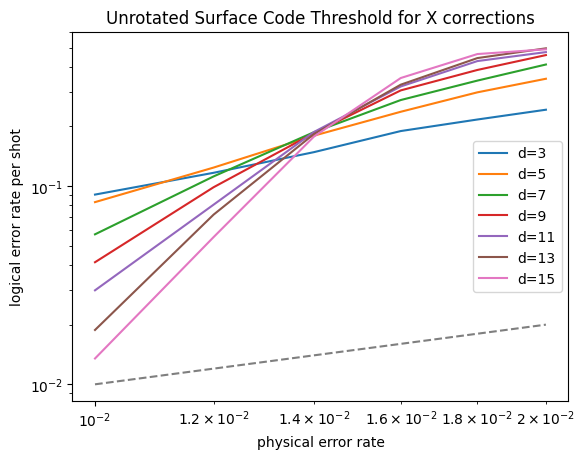

In [71]:
import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7, 9, 11, 13, 15]:
    sc = qldpc.codes.SurfaceCode(d, rotated=False)
    xs = []
    ys = []
    for noise in [0.01, 0.012, 0.014, 0.016, 0.018, 0.02]:
        circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(sc, 3*d, noise))
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("Unrotated Surface Code Threshold for X corrections")
plt.legend()
plt.show()

In [8]:
qldpc.codes.GBCode()

TypeError: GBCode.__init__() missing 2 required positional arguments: 'matrix_a' and 'matrix_b'

In [12]:
distance = 5
ca = qldpc.codes.RepetitionCode(distance)
cb = qldpc.codes.RepetitionCode(distance)
hgp = qldpc.codes.HGPCode(ca, cb)

In [14]:
gen_syndrome_surface_circuit(hgp, repetitions=1, error_rate=0.01)

┌─────┐                                ┌──────┐                                ┌───────┐                                ┌────────┐                                ┌──────────┐                                ┌───────────┐                                ┌─────────────┐                                ┌──────────────┐                                ┌────────────┐                                ┌───────────┐                                ┌───────────┐                                ┌──────────┐                                ┌────────┐                                ┌───────┐                                ┌─────┐                                ┌────┐                                ┌──┐
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        [             ┌─────┐   ┌──────┐   ┌───────┐   ┌────────┐   ┌──────────┐   ┌───────────┐   ┌─────────────┐   ┌──────────────┐   ┌────────────┐   ┌───────────┐   ┌───────────┐   ┌──────────┐   ┌────────┐   ┌───────┐   ┌─────┐   ┌────┐   ┌──┐                                                                              ]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        [ 0: ──────────X──────────────X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── ]
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

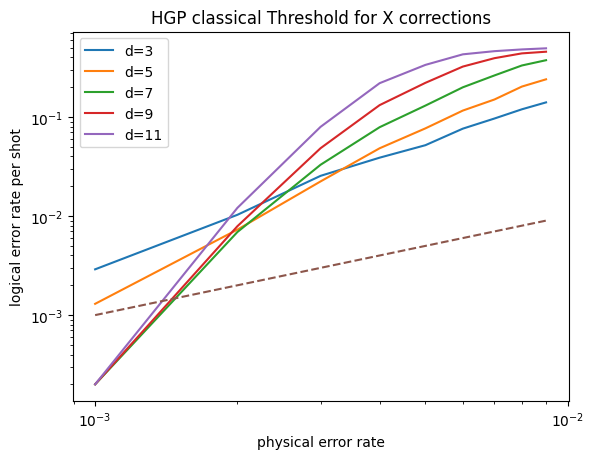

In [23]:
import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7, 9, 11]:
    ca = qldpc.codes.RepetitionCode(d)
    cb = qldpc.codes.RepetitionCode(d)
    hgp = qldpc.codes.HGPCode(ca, cb)
    xs = []
    ys = []
    for noise in np.arange(0.001, 0.01, 0.001):
        circuit = stimcirq.cirq_circuit_to_stim_circuit(gen_syndrome_surface_circuit(hgp, 3*d, noise))
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.plot(xs, xs, "--")
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.title("HGP classical Threshold for X corrections")
plt.legend()
plt.show()

In [18]:
qldpc.codes.HammingCode(3)